<a href="https://colab.research.google.com/github/suebatista/hackathon/blob/main/dermatite_inss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DATATHON - DERMATITE ATÓPICA**#
Eretz.bio / Hospital Albert Einstein / Apoio: Abbvie <br>

**Grupo de trabalho:**<br>
DataDES

**Integrantes:** <br>
Danilo Gouvea Silva<br>
Eduardo R. Malaquias Chagas<br>
Suelen Cristina Batista da Silva

**Esse notebook responde a parte da PERGUNTA 3 referente aos benefícios do INSS**


##**PREPARAÇÃO DO NOTEBOOK E IMPORTAÇÃO DOS DATASETS**##

In [1]:
# Import libraries
from google.colab import files
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import graphing libraries
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Import PyDrive and associated libraries
# This only needs to be done once per notebook session
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Import data sets from Google Drive
# This only needs to be done once per notebook session

# '/datathon-dermatite/data/' Google Drive folder id 
data_id = '1TNeTdeTIez7hZZwOc0WsewaD_n3vzoGx'

# List folders under '/datathon-dermatite/data/'
folders = drive.ListFile({'q': "mimeType contains '.folder' and '{}' in parents".format(data_id)}).GetList()
for folder in folders:
    if 'inss' in folder['title']:
        Path.mkdir(Path() / 'data' / folder['title'], parents=True, exist_ok=True)
        files = drive.ListFile({'q': "title contains '.parquet' and '{}' in parents".format(folder['id'])}).GetList()
        for fn in files:
            # Download file
            fn_id = fn['id']
            fn_title = fn['title']
            downloaded = drive.CreateFile({'id': fn_id, 'title': fn_title})
            downloaded.GetContentFile(fn_title)

            # Move file to right folder
            filepath = Path().cwd() / fn_title
            Path(filepath).rename(Path().cwd() / 'data' / folder['title'] / fn_title)

            # Success message
            print(f'"{fn_title}" successfully imported to "./data/{folder["title"]}"')
  
# Success message
print('ALL FILES IMPORTED!')


"INSS_beneficios_indeferidos.parquet" successfully imported to "./data/inss_beneficios"
"INSS_beneficios_concedidos.parquet" successfully imported to "./data/inss_beneficios"
ALL FILES IMPORTED!


##**PERGUNTA 3**##
**Comparação com outros CIDs de doenças crônicas: L40 (psoríase) e L73.2 (hidradenite supurativa)**

###INSS - BENEFÍCIOS CONCEDIDOS###


In [4]:
# Create dataframe
file_path = Path('data/inss_beneficios/INSS_beneficios_concedidos.parquet')
df_concedidos = pd.read_parquet(file_path, engine='pyarrow')

In [5]:
df_concedidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11631138 entries, 0 to 433675
Data columns (total 14 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Competência concessão  int64 
 1   Espécie                object
 2   CID                    object
 3   CID.1                  object
 4   Despacho               object
 5   Dt Nascimento          object
 6   Sexo.                  object
 7   Clientela              object
 8   Mun Resid              object
 9   Vínculo dependentes    object
 10  Forma Filiação         object
 11  UF                     object
 12  Qt SM RMI              object
 13  CID_1                  object
dtypes: int64(1), object(13)
memory usage: 1.3+ GB


In [6]:
df_concedidos.head(2)

,Competência concessão,Espécie,CID,CID.1,Despacho,Dt Nascimento,Sexo.,Clientela,Mun Resid,Vínculo dependentes,Forma Filiação,UF,Qt SM RMI,CID_1
0,201901,Auxílio Doenca Previdenciário,I83,I83 Varizes dos Membros Infer,Concessao Normal,25/10/1967,Feminino,Urbano,02003-AL-Arapiraca,Filho,Empregado,Alagoas,"1,068",None
1,201901,Auxílio Doenca Previdenciário,S525,S52.5 Frat da Extremidade Distal do Radio,Conc. Base Artigo 27 Inciso Ii do Rbps,16/05/1994,Masculino,Urbano,02003-AL-Arapiraca,Não Informado,Empregado,Alagoas,"1,099",None


In [7]:
df_concedidos['Dt Nascimento'] = pd.to_datetime(df_concedidos['Dt Nascimento'], infer_datetime_format=True, errors='coerce')
df_concedidos['ANO'] = df_concedidos['Competência concessão'] // 100
df_concedidos['MÊS'] = df_concedidos['Competência concessão'] % 100
df_concedidos['IDADE'] = df_concedidos['ANO'] - df_concedidos['Dt Nascimento'].dt.year
df_concedidos['CID_SHORT'] = df_concedidos.CID.str[:3]
df_concedidos['Qt SM RMI'] = df_concedidos['Qt SM RMI'].str.replace(',', '.').astype('float')

In [8]:
# Create column 'FAIXA_ETARIA'
df_concedidos['FAIXA_ETARIA'] = np.nan
df_concedidos.FAIXA_ETARIA = pd.cut(df_concedidos.IDADE, [0, 5, 11, 17, 29, 49, 150], labels=['0-6', '6-12', '12-18', '18-30', '30-50', '50+'], include_lowest=True)

In [39]:
# Filter dataframe for all L20 and L40 CIDs and L732 specifically
df = df_concedidos[(df_concedidos.ANO != 2021) & ((df_concedidos.CID.str[:3].isin(['L20', 'L40'])) | (df_concedidos.CID == 'L732'))].copy()

In [130]:
# Cast 'ANO' as 'object'
df['ANO'] = df['ANO'].astype('string')

In [131]:
df.head(2)

,Competência concessão,Espécie,CID,CID.1,Despacho,Dt Nascimento,Sexo.,Clientela,Mun Resid,Vínculo dependentes,...,Qt SM RMI,CID_1,ANO,MÊS,IDADE,CID_SHORT,FAIXA_ETARIA,SM,DURAÇÃO_BENEFÍCIO,VALOR_ANUAL
841,201901,Auxílio Doenca Previdenciário,L40,L40 Psoriase,Concessao Normal,1966-06-12,Masculino,Rural,04039-BA-Bom Jesus da Lapa,Não Informado,...,1.0,None,2019,1,53.0,L40,50+,NaN,6,NaN
2195,201901,Amp. Social Pessoa Portadora Deficiencia,L209,L20.9 Dermatite Atopica Ne,Concessao Normal,2005-10-20,Masculino,Urbano,05043-CE-Crato,Não Informado,...,1.0,None,2019,1,14.0,L20,12-18,NaN,12,NaN


**3.1 Quantos benefícios solicitados e concedidos comparativamente entre as doenças?**

In [71]:
cids = df[df.ANO != 2021].groupby(['ANO', 'CID_SHORT']).agg(
    CID=pd.NamedAgg('CID.1', 'first'),
    NUM_BENEFICIOS=pd.NamedAgg('CID_SHORT', 'count')
).sort_values(['ANO', 'NUM_BENEFICIOS'], ascending=[True, False])

cids['PORCENTAGEM'] = np.NaN

for year in cids.reset_index().ANO.unique():
  total = cids.loc[year].NUM_BENEFICIOS.sum()
  cids.loc[year, 'PORCENTAGEM'] = round(cids.NUM_BENEFICIOS / total * 100, 1)

cids[['NUM_BENEFICIOS','PORCENTAGEM']]

NUM_BENEFICIOS  PORCENTAGEM
ANO  CID_SHORT                             
2019 L40                  1378         69.5
     L20                   303         15.3
     L73                   303         15.3
2020 L40                   466         69.2
     L73                   111         16.5
     L20                    96         14.3

In [42]:
mask_cids = cids.reset_index().replace({'CID_SHORT' : { 'L20' : 'Dermatite atópica', 'L40' : 'Psoríase', 'L73' : 'Hidradenite Supurativa' }})

In [43]:
px.bar(mask_cids.reset_index(),x='ANO',y='NUM_BENEFICIOS',color='CID_SHORT',title= 'Quantos benefícios solicitados e concedidos comparativamente entre as doenças?',barmode='group')

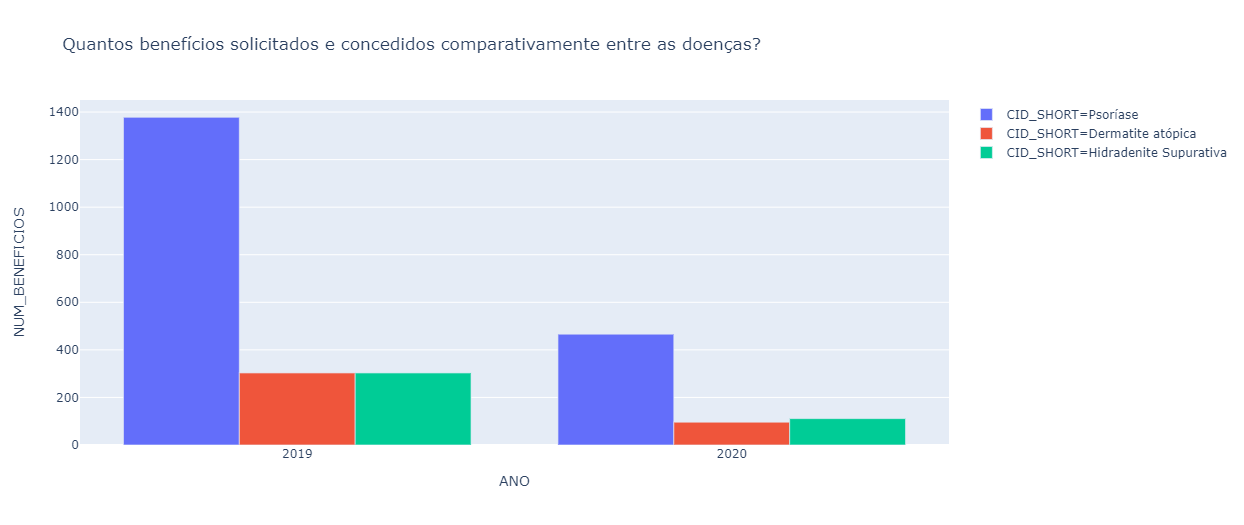

**3.2 Qual a faixa etária que mais solicita em cada uma das doenças?**


In [44]:
age_groups = df[df.ANO != 2021].groupby(['CID_SHORT', 'FAIXA_ETARIA']).agg(
    NUM_BENEFICIOS=pd.NamedAgg('FAIXA_ETARIA', 'count')
).sort_values(['CID_SHORT', 'NUM_BENEFICIOS'], ascending=[True, False])

age_groups['PORCENTAGEM'] = np.NaN

for cid in age_groups.reset_index().CID_SHORT.unique():
  total = age_groups.loc[cid].NUM_BENEFICIOS.sum()
  age_groups.loc[cid, 'PORCENTAGEM'] = round(age_groups.NUM_BENEFICIOS / total * 100, 1)

age_groups

NUM_BENEFICIOS  PORCENTAGEM
CID_SHORT FAIXA_ETARIA                             
L20       30-50                    180         45.1
          50+                      107         26.8
          18-30                     88         22.1
          0-6                       13          3.3
          6-12                       9          2.3
          12-18                      2          0.5
L40       50+                      879         47.7
          30-50                    853         46.3
          18-30                    103          5.6
          6-12                       7          0.4
          0-6                        1          0.1
          12-18                      1          0.1
L73       30-50                    251         60.6
          18-30                    106         25.6
          50+                       57         13.8
          0-6                        0          0.0
          6-12                       0          0.0
          12-18                      0          0.0

In [45]:
mask = age_groups.reset_index().replace({'CID_SHORT': {'L20': 'Dermatite atópica', 'L40': 'Psoríase', 'L73': 'Hidradenite Supurativa' }})

In [46]:
fig = px.bar(mask.reset_index(),x='CID_SHORT',y='NUM_BENEFICIOS',color='FAIXA_ETARIA',title='Qual a faixa etária que mais solicita benefícios em cada uma das doenças?',barmode="group",labels={
                     'FAIXA_ETARIA': "Faixa etária",
                     'NUM_BENEFICIOS': "Número de benefícios",
                     'CID_SHORT': "CID"
                 })


fig.show()

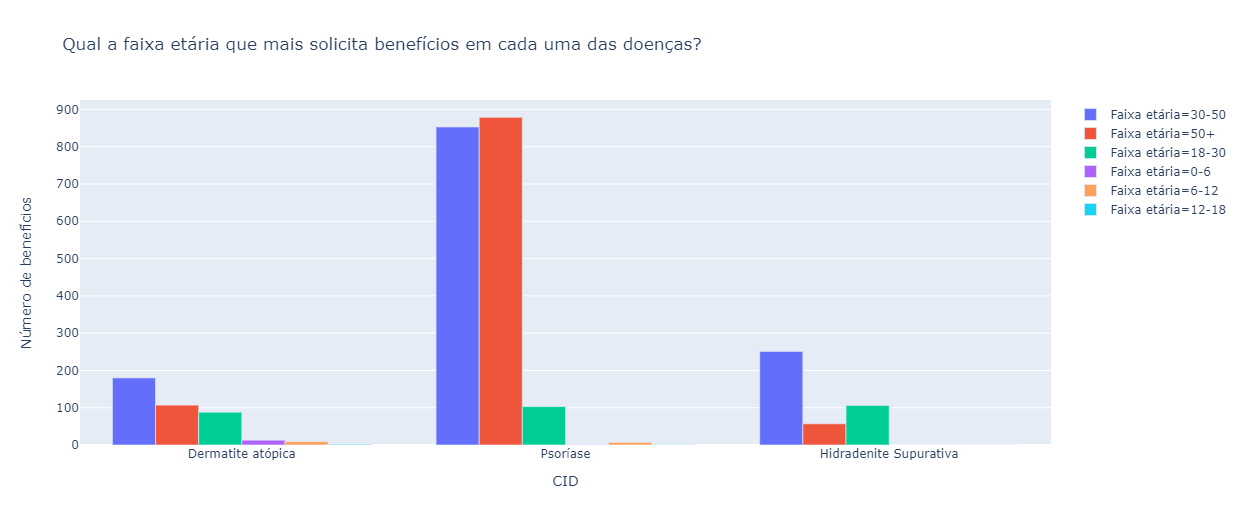

**3.3 Quais tipos de benefícios mais solicitados e mais concedidos?**

In [72]:
benefits = df[df.ANO != 2021].groupby(['CID_SHORT', 'Espécie']).agg(
    NUM_BENEFICIOS=pd.NamedAgg('CID_SHORT', 'count')
).sort_values(['CID_SHORT', 'NUM_BENEFICIOS'], ascending=[True, False])

benefits['PORCENTAGEM'] = np.NaN

for cid in benefits.reset_index().CID_SHORT.unique():
  total = benefits.loc[cid].NUM_BENEFICIOS.sum()
  benefits.loc[cid, 'PORCENTAGEM'] = round(benefits.NUM_BENEFICIOS / total * 100, 1)

benefits

NUM_BENEFICIOS  \
CID_SHORT Espécie                                                    
L20       Auxílio Doenca Previdenciário                        350   
          Amp. Social Pessoa Portadora Deficiencia              30   
          Aposentadoria Invalidez Previdenciária                 9   
          Auxílio Doenca por Acidente do Trabalho                9   
          Aposent. Invalidez Acidente Trabalho                   1   
L40       Auxílio Doenca Previdenciário                       1559   
          Aposentadoria Invalidez Previdenciária               208   
          Amp. Social Pessoa Portadora Deficiencia              71   
          Auxílio Doenca por Acidente do Trabalho                5   
          Aposent. Invalidez Acidente Trabalho                   1   
L73       Auxílio Doenca Previdenciário                        383   
          Aposentadoria Invalidez Previdenciária                28   
          Amp. Social Pessoa Portadora Deficiencia               3   

                                                    PORCENTAGEM  
CID_SHORT Espécie                                                
L20       Auxílio Doenca Previdenciário                    87.7  
          Amp. Social Pessoa Portadora Deficiencia          7.5  
          Aposentadoria Invalidez Previdenciária            2.3  
          Auxílio Doenca por Acidente do Trabalho           2.3  
          Aposent. Invalidez Acidente Trabalho              0.3  
L40       Auxílio Doenca Previdenciário                    84.5  
          Aposentadoria Invalidez Previdenciária           11.3  
          Amp. Social Pessoa Portadora Deficiencia          3.9  
          Auxílio Doenca por Acidente do Trabalho           0.3  
          Aposent. Invalidez Acidente Trabalho              0.1  
L73       Auxílio Doenca Previdenciário                    92.5  
          Aposentadoria Invalidez Previdenciária            6.8  
          Amp. Social Pessoa Portadora Deficiencia          0.7

In [48]:
mask_benefits = benefits.reset_index().replace({'CID_SHORT' : { 'L20' : 'Dermatite atópica', 'L40' : 'Psoríase', 'L73' : 'Hidradenite Supurativa' }})

In [49]:
px.bar(mask_benefits.reset_index(),x='CID_SHORT',y='NUM_BENEFICIOS',color='Espécie',barmode='group',title='Quais tipos de benefícios mais solicitados e mais concedidos?')

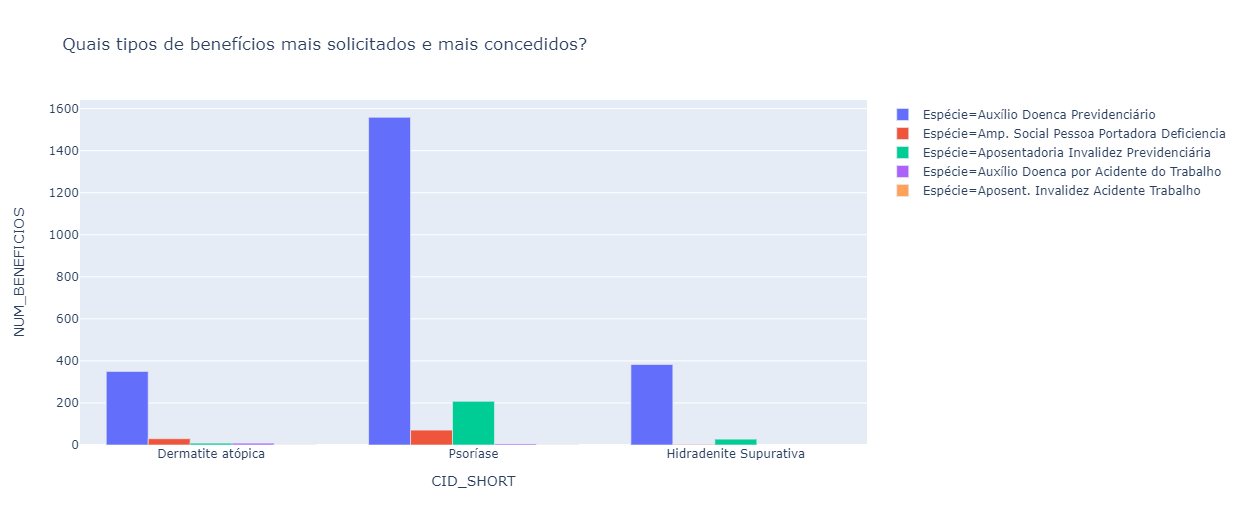

**3.4 Custo global dos benefícios solicitados para CID L20**

In [132]:
# Salário Mínimo (SM)
SM = {'2019': 998.0,
      '2020': 1045.0,
      '2021': 1100.0}

# Create columns SM
df['SM'] = df.ANO.map(SM)

In [134]:
# Duração de cada benefício em meses
duration = {
    'Auxílio Doenca Previdenciário': 6,
    'Amp. Social Pessoa Portadora Deficiencia': 12,
    'Aposentadoria Invalidez Previdenciária': 12,
    'Auxílio Doenca por Acidente do Trabalho': 6,
    'Aposent. Invalidez Acidente Trabalho': 12
}

In [142]:
# Meses de benefício
df['DURAÇÃO_BENEFÍCIO'] = df['Espécie'].map(duration)

# Valor anual de benefício
df['VALOR_ANUAL'] = df['Qt SM RMI'] * df['SM'] * df['DURAÇÃO_BENEFÍCIO']

In [149]:
global_cost = df.loc[df.CID_SHORT == 'L20'].groupby('ANO')[['VALOR_ANUAL']].sum()
global_cost

,VALOR_ANUAL
ANO,
2019,2645175.048
2020,833138.790


In [151]:
px.bar(
    global_cost.reset_index(),
    x='ANO',
    y='VALOR_ANUAL',
    text_auto='.2s',
    title='Custo global (em R$) dos benefícios solicitados para CID L20 por ano'
)

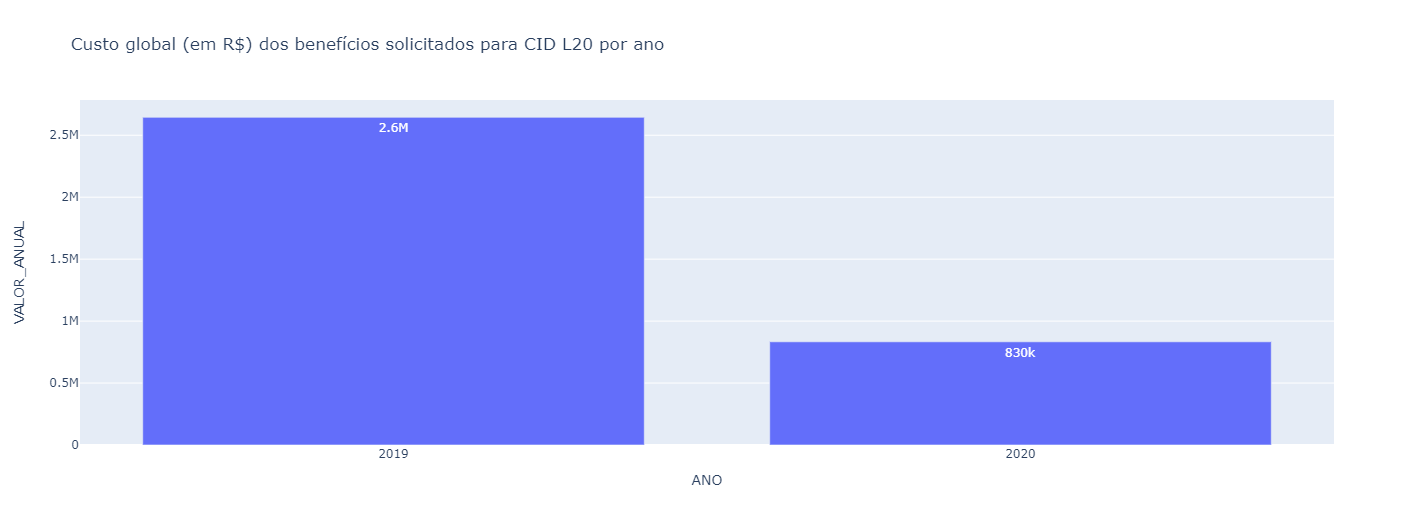

**3.5 Comparação de benefícios concedidos para CIDs L20, L40 e L73.2**

In [145]:
comparison_cost = df.groupby(['ANO', 'CID_SHORT'])[['VALOR_ANUAL']].sum()
comparison_cost

VALOR_ANUAL
ANO  CID_SHORT              
2019 L20        2.645175e+06
     L40        1.325165e+07
     L73        2.788941e+06
2020 L20        8.331388e+05
     L40        4.101144e+06
     L73        9.544633e+05

In [153]:
px.bar(
    comparison_cost.reset_index(),
    x='ANO',
    y='VALOR_ANUAL',
    color='CID_SHORT',
    barmode='group',
    text_auto='.2s',
    title='Custo global (em R$) dos benefícios solicitados para os CIDs L20, L40 e L73.2 por ano'
)

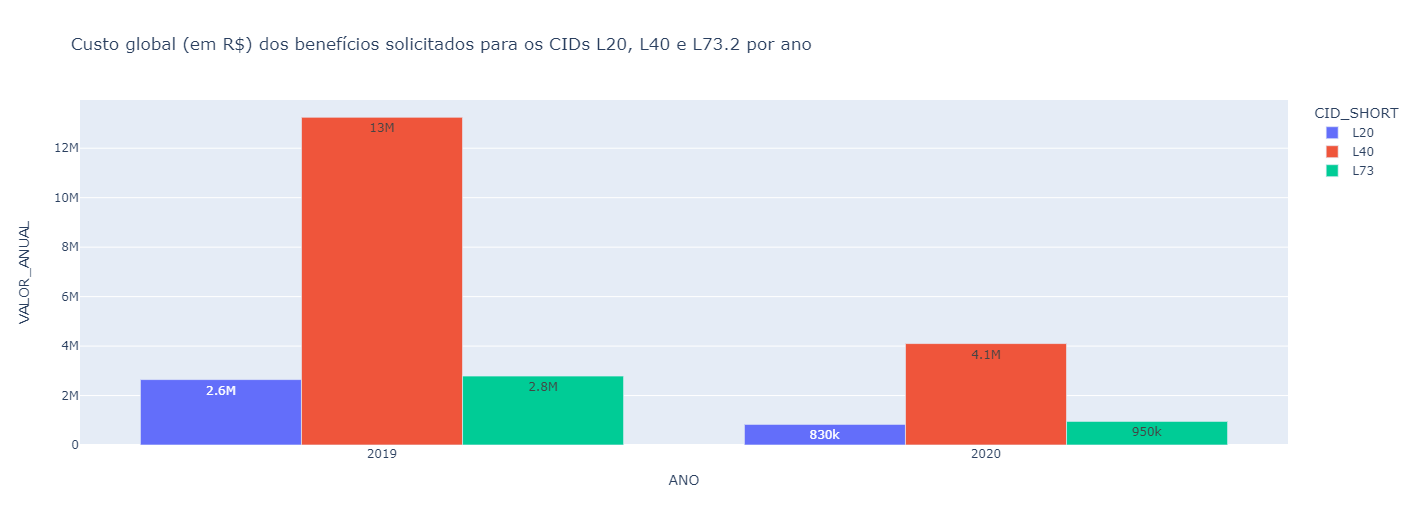

### INSS - BENEFÍCIOS INDEFERIDOS###
**Não há nenhum campo na tabela de benefícios indeferidos que possa relacionar o registro com o tipo/CID de doença. Logo, infelizmente, não é possível gerar conhecimento sobre benefícios indeferidos que foram solicitados devido ao CID de Dermatite Atópica ou outros doenças crônicas de pele**

In [ ]:
# Create dataframe
file_path = Path('data/inss_beneficios/INSS_beneficios_indeferidos.parquet')
df_indeferidos = pd.read_parquet(file_path, engine='pyarrow')

In [ ]:
df_indeferidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10274832 entries, 0 to 373459
Data columns (total 9 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   Competência indeferimento  object
 1   Espécie                    object
 2   Motivo Indeferimento       object
 3   Dt Nascimento              object
 4   Sexo.                      object
 5   Clientela                  object
 6   Forma Filiação             object
 7   UF                         object
 8   Dt Indeferimento           object
dtypes: object(9)
memory usage: 783.9+ MB


In [ ]:
df_indeferidos.head()

,Competência indeferimento,Espécie,Motivo Indeferimento,Dt Nascimento,Sexo.,Clientela,Forma Filiação,UF,Dt Indeferimento
0,201901,Aposentadoria por Tempo de Contribuição,Falta Tempo Contrib Ativs nos Dss8030 e Laudos...,02/05/1963,Feminino,Urbano,Desempregado,Alagoas,02/01/2019
1,201901,Aposentadoria por Tempo de Contribuição,Falta Tempo Contrib Ativs nos Dss8030 e Laudos...,12/07/1967,Masculino,Urbano,Desempregado,Alagoas,02/01/2019
2,201901,Aposentadoria por Tempo de Contribuição,Falta Tempo Contrib Ativs nos Dss8030 e Laudos...,01/01/1966,Masculino,Urbano,Desempregado,Alagoas,02/01/2019
3,201901,Auxílio Salario Maternidade,Parto/Guarda para Fins Adocao sem Qualidade de...,03/03/1978,Feminino,Urbano,Doméstico,Alagoas,04/01/2019
4,201901,Aposentadoria por Tempo de Contribuição,Falta Tempo Contrib Ativs nos Dss8030 e Laudos...,04/02/1966,Masculino,Urbano,Desempregado,Alagoas,04/01/2019
